<a href="https://colab.research.google.com/github/Idybaz/Gold_Price_Prediction98/blob/main/ANNAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing Libraries and Packages**

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
# impport neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, GRU, SimpleRNN
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time
import keras_tuner as kt
import tensorflow as tf

# **Loading and Preprocessing the Data**

In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Gold Price (2013-2023).csv')

# Drop unnecessary columns
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort values by Date
df.sort_values(by='Date', ascending=True, inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

# Convert Price column to float
df['Price'] = df['Price'].str.replace(',', '').astype(float)

# Display the first few rows of the dataframe
print(df.head())

        Date   Price      Open      High       Low
0 2013-01-02  1689.9  1,675.80  1,695.00  1,672.10
1 2013-01-03  1675.6  1,688.00  1,689.30  1,664.30
2 2013-01-04  1649.9  1,664.40  1,664.40  1,630.00
3 2013-01-07  1647.2  1,657.30  1,663.80  1,645.30
4 2013-01-08  1663.2  1,651.50  1,662.60  1,648.80


# **Exploratory Data Analysis**

Basic statistics of the dataset:
                                Date        Price       SMA_30       SMA_90
count                           2583  2583.000000  2554.000000  2494.000000
mean   2018-01-02 02:17:08.571428608  1440.326442  1436.927585  1431.431360
min              2013-01-02 00:00:00  1049.600000  1068.293333  1103.573333
25%              2015-07-02 12:00:00  1244.200000  1244.355833  1249.241389
50%              2018-01-03 00:00:00  1320.500000  1313.830000  1303.094444
75%              2020-07-04 12:00:00  1713.950000  1708.585000  1714.501667
max              2022-12-30 00:00:00  2058.400000  1965.616667  1924.983333
std                              NaN   257.338282   254.886067   252.141730


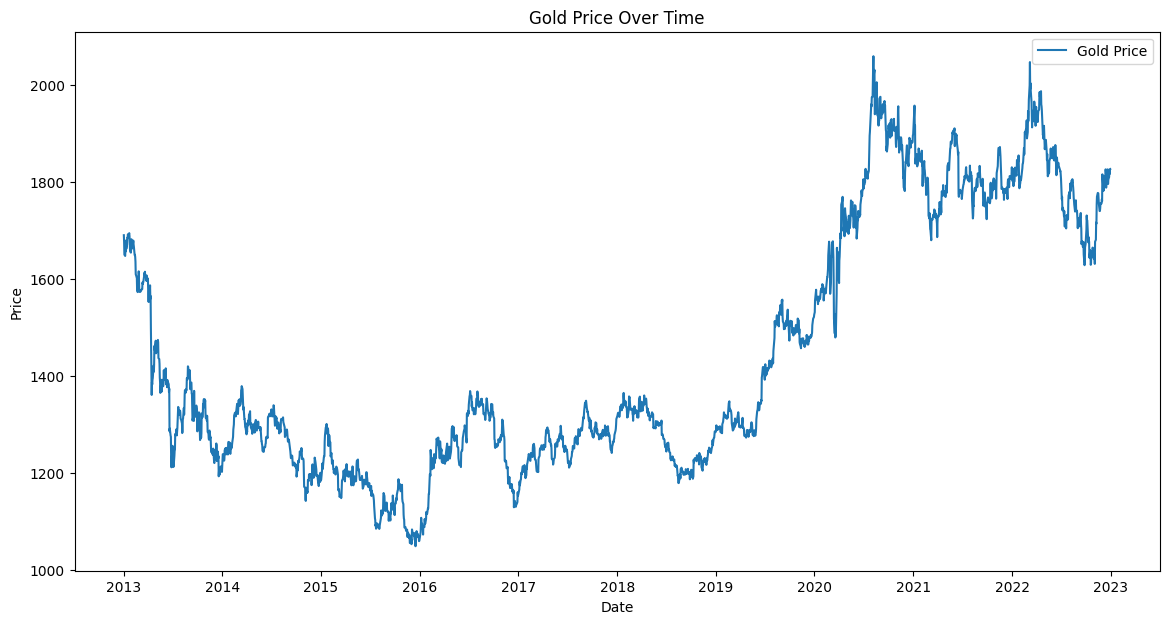

Gold price over time plot displayed.


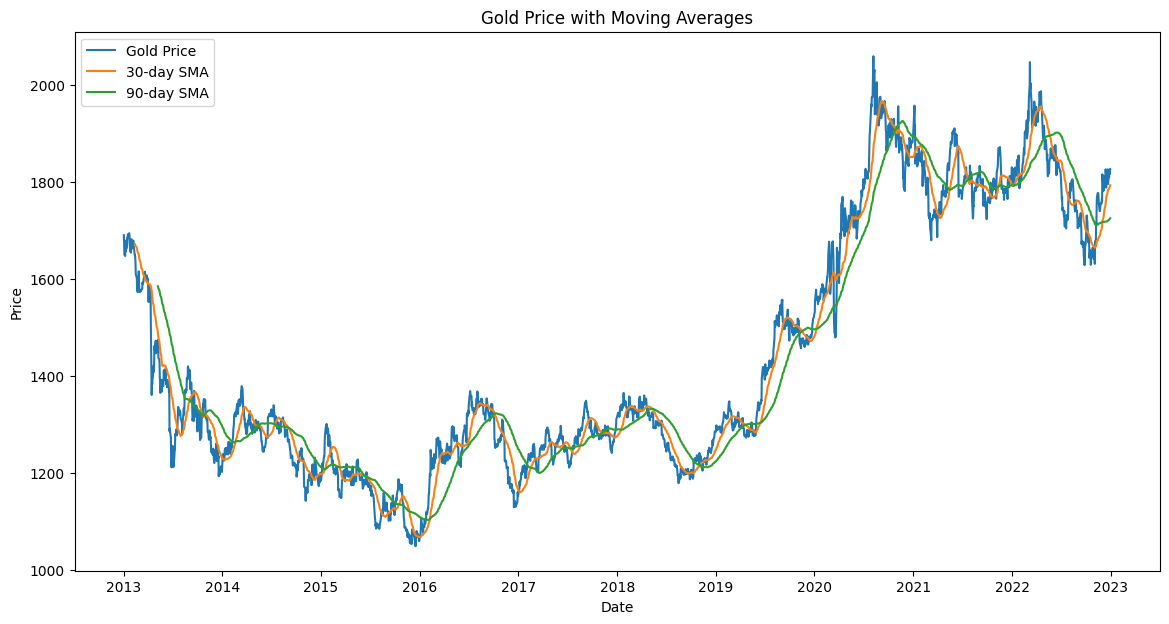

Moving averages plot displayed.


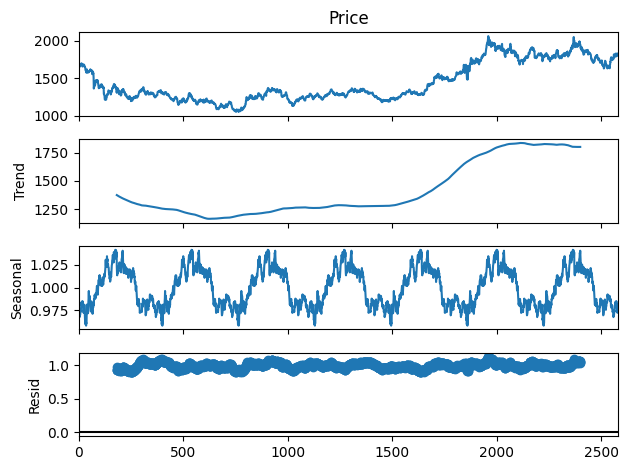

Seasonal decomposition plot displayed.


In [ ]:
# Display basic statistics of the dataset
print("Basic statistics of the dataset:")
print(df.describe())

# Plot the price over time
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Price'], label='Gold Price')
plt.title('Gold Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

print("Gold price over time plot displayed.")

# Calculate moving averages
df['SMA_30'] = df['Price'].rolling(window=30).mean()
df['SMA_90'] = df['Price'].rolling(window=90).mean()

# Plot the price with moving averages
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Price'], label='Gold Price')
plt.plot(df['Date'], df['SMA_30'], label='30-day SMA')
plt.plot(df['Date'], df['SMA_90'], label='90-day SMA')
plt.title('Gold Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

print("Moving averages plot displayed.")

# Perform seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Price'], model='multiplicative', period=365)
result.plot()
plt.show()
print("Seasonal decomposition plot displayed.")



Normalize and Spilt Data into Training and Testing

In [ ]:
# Drop rows with NaN values (caused by rolling window)
df.dropna(inplace=True)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

# Normalizing the data using MinMaxScaler
scaler = MinMaxScaler()
df[['Price', 'SMA_30', 'SMA_90']] = scaler.fit_transform(df[['Price', 'SMA_30', 'SMA_90']])

print("Data normalized.")

# Split the data into training and testing sets
test_size = df[df['Date'].dt.year == 2022].shape[0]
train_data = df.iloc[:-test_size]
test_data = df.iloc[-test_size:]

print(f"Training data size: {train_data.shape}")
print(f"Testing data size: {test_data.shape}")


Data normalized.
Training data size: (2234, 7)
Testing data size: (260, 7)


Creating Sequences

In [ ]:
# Function to create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, :])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Define window size
window_size = 60

# Prepare training data
train_values = train_data[['Price', 'SMA_30', 'SMA_90']].values
X_train, y_train = create_sequences(train_values, window_size)

# Prepare testing data
test_values = test_data[['Price', 'SMA_30', 'SMA_90']].values
X_test, y_test = create_sequences(test_values, window_size)

# Reshape y_train and y_test
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)


X_train shape: (2174, 60, 3)
y_train shape: (2174, 1)
X_test shape: (200, 60, 3)
y_test shape: (200, 1)


 Defining Callbacks

In [ ]:
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

print("Callbacks defined.")


Callbacks defined.


**Defining Model Building Functions**

LSTM Model Building

In [ ]:
def build_lstm_model(hp):
    input1 = Input(shape=(window_size, 3))
    x = LSTM(units=hp.Int('units1', min_value=32, max_value=128, step=32), return_sequences=True)(input1)
    x = Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.4, step=0.1))(x)
    x = LSTM(units=hp.Int('units2', min_value=32, max_value=128, step=32), return_sequences=True)(x)
    x = Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.4, step=0.1))(x)
    x = LSTM(units=hp.Int('units3', min_value=32, max_value=128, step=32))(x)
    x = Dropout(hp.Float('dropout3', min_value=0.2, max_value=0.4, step=0.1))(x)
    x = Dense(32, activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=dnn_output)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

print("LSTM model building function defined.")


LSTM model building function defined.


GRU Model Building

In [ ]:
def build_gru_model(hp):
    input1 = Input(shape=(window_size, 3))
    x = GRU(units=hp.Int('units1', min_value=32, max_value=128, step=32), return_sequences=True)(input1)
    x = Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.4, step=0.1))(x)
    x = GRU(units=hp.Int('units2', min_value=32, max_value=128, step=32), return_sequences=True)(x)
    x = Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.4, step=0.1))(x)
    x = GRU(units=hp.Int('units3', min_value=32, max_value=128, step=32))(x)
    x = Dropout(hp.Float('dropout3', min_value=0.2, max_value=0.4, step=0.1))(x)
    x = Dense(32, activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=dnn_output)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

print("GRU model building function defined.")


GRU model building function defined.


SimpleRNN Model Building

In [ ]:
def build_rnn_model(hp):
    input1 = Input(shape=(window_size, 3))
    x = SimpleRNN(units=hp.Int('units1', min_value=32, max_value=128, step=32), return_sequences=True)(input1)
    x = Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.4, step=0.1))(x)
    x = SimpleRNN(units=hp.Int('units2', min_value=32, max_value=128, step=32), return_sequences=True)(x)
    x = Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.4, step=0.1))(x)
    x = SimpleRNN(units=hp.Int('units3', min_value=32, max_value=128, step=32))(x)
    x = Dropout(hp.Float('dropout3', min_value=0.2, max_value=0.4, step=0.1))(x)
    x = Dense(32, activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=dnn_output)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

print("SimpleRNN model building function defined.")


SimpleRNN model building function defined.


**Hyperparameter Tuning**

In [ ]:
# Define the tuner
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    tuner_lstm = kt.Hyperband(build_lstm_model, objective='val_loss', max_epochs=20, factor=3, directory='my_dir', project_name='lstm_tuning')
    tuner_gru = kt.Hyperband(build_gru_model, objective='val_loss', max_epochs=20, factor=3, directory='my_dir', project_name='gru_tuning')
    tuner_rnn = kt.Hyperband(build_rnn_model, objective='val_loss', max_epochs=20, factor=3, directory='my_dir', project_name='rnn_tuning',)



In [ ]:
# Search for the best hyperparameters
print("Searching for the best hyperparameters for LSTM model...")
tuner_lstm.search(X_train, y_train, epochs=20, validation_split=0.1, callbacks=[early_stopping, reduce_lr])
best_lstm_model = tuner_lstm.get_best_models(num_models=1)[0]

Trial 30 Complete [00h 01m 29s]
val_loss: 0.0017761082854121923

Best val_loss So Far: 0.0005799204809591174
Total elapsed time: 00h 54m 05s


In [ ]:
print("Searching for the best hyperparameters for GRU model...")
tuner_gru.search(X_train, y_train, epochs=20, validation_split=0.1, callbacks=[early_stopping, reduce_lr])
best_gru_model = tuner_gru.get_best_models(num_models=1)[0]

Trial 30 Complete [00h 01m 53s]
val_loss: 0.0007723068702034652

Best val_loss So Far: 0.00037070910912007093
Total elapsed time: 00h 43m 09s


In [ ]:
print("Searching for the best hyperparameters for SimpleRNN model...")
tuner_rnn.search(X_train, y_train, epochs=20, validation_split=0.1, callbacks=[early_stopping, reduce_lr])
best_rnn_model = tuner_rnn.get_best_models(num_models=1)[0]

print("Hyperparameter tuning completed.")

Trial 30 Complete [00h 00m 52s]
val_loss: 0.004487353377044201

Best val_loss So Far: 0.0011158062843605876
Total elapsed time: 00h 19m 36s
Hyperparameter tuning completed.


In [ ]:
# Display the best hyperparameters for each model
best_lstm_hps = tuner_lstm.get_best_hyperparameters(num_trials=1)[0]
best_gru_hps = tuner_gru.get_best_hyperparameters(num_trials=1)[0]
best_rnn_hps = tuner_rnn.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters for LSTM Model:")
for key, value in best_lstm_hps.values.items():
    print(f"{key}: {value}")

print("\nBest Hyperparameters for GRU Model:")
for key, value in best_gru_hps.values.items():
    print(f"{key}: {value}")

print("\nBest Hyperparameters for SimpleRNN Model:")
for key, value in best_rnn_hps.values.items():
    print(f"{key}: {value}")


Best Hyperparameters for LSTM Model:
units1: 128
dropout1: 0.2
units2: 128
dropout2: 0.2
units3: 128
dropout3: 0.30000000000000004
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012

Best Hyperparameters for GRU Model:
units1: 96
dropout1: 0.30000000000000004
units2: 96
dropout2: 0.2
units3: 128
dropout3: 0.30000000000000004
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020

Best Hyperparameters for SimpleRNN Model:
units1: 32
dropout1: 0.4
units2: 32
dropout2: 0.2
units3: 128
dropout3: 0.30000000000000004
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012


**Training and Evaluating the Models**

Trian LSTM Model

In [ ]:
# Train the best LSTM model
print("Training the best LSTM model...")
start_time = time.time()
history_lstm = best_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1, callbacks=[early_stopping, reduce_lr])
end_time = time.time()
lstm_training_time = end_time - start_time

# Evaluate the best LSTM model
lstm_result = best_lstm_model.evaluate(X_test, y_test)
y_pred_lstm = best_lstm_model.predict(X_test)
lstm_mape = mean_absolute_percentage_error(y_test, y_pred_lstm)
lstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
lstm_accuracy = 1 - lstm_mape

print(f"LSTM Model: Test Loss = {lstm_result}, Test MAPE = {lstm_mape}, Test RMSE = {lstm_rmse}, Test Accuracy = {lstm_accuracy}, Training Time = {lstm_training_time} seconds")



Training the best LSTM model...
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 321ms/step - loss: 0.0013 - val_loss: 5.8074e-04 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 318ms/step - loss: 0.0015 - val_loss: 6.5413e-04 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 381ms/step - loss: 8.6720e-04 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 39s 355ms/step - loss: 9.1058e-04 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 318ms/step - loss: 7.0046e-04 - val_loss: 5.2329e-04 - learning_rate: 5.0000e-04
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - loss: 6.8887e-04 - val_loss: 9.5179e-04 - learning_rate: 5.0000e-04
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 348ms/step - loss: 6.9987e-04 - val_loss: 4.8737e-04 - learning_rate: 5.0000e-04
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 39s 314ms/step - loss: 6.9793e-04 - val_loss: 4.4694e-04 - learning_rate: 2.5000e-04
Epoch 9/50
62/62

Train GRU Model

In [ ]:
# Train the best GRU model
print("Training the best GRU model...")
start_time = time.time()
history_gru = best_gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1, callbacks=[early_stopping, reduce_lr])
end_time = time.time()
gru_training_time = end_time - start_time

# Evaluate the best GRU model
gru_result = best_gru_model.evaluate(X_test, y_test)
y_pred_gru = best_gru_model.predict(X_test)
gru_mape = mean_absolute_percentage_error(y_test, y_pred_gru)
gru_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gru))
gru_accuracy = 1 - gru_mape

print(f"GRU Model: Test Loss = {gru_result}, Test MAPE = {gru_mape}, Test RMSE = {gru_rmse}, Test Accuracy = {gru_accuracy}, Training Time = {gru_training_time} seconds")



Training the best GRU model...
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 217ms/step - loss: 0.0018 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - loss: 7.2087e-04 - val_loss: 3.4167e-04 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - loss: 9.8362e-04 - val_loss: 9.9339e-04 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - loss: 7.8322e-04 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - loss: 8.9893e-04 - val_loss: 3.2569e-04 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step - loss: 6.3574e-04 - val_loss: 4.6777e-04 - learning_rate: 5.0000e-04
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 208ms/step - loss: 7.2682e-04 - val_loss: 0.0023 - learning_rate: 5.0000e-04
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 185ms/step - loss: 6.5788e-04 - val_loss: 0.0022 - learning_rate: 5.0000e-04
Epoch 9/50
62/62 ━━━━━━━━

Trian SimpleRNN Model

In [ ]:
# Train the best SimpleRNN model
print("Training the best SimpleRNN model...")
start_time = time.time()
history_rnn = best_rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)
end_time = time.time()
rnn_training_time = end_time - start_time

# Evaluate the best SimpleRNN model
rnn_result = best_rnn_model.evaluate(X_test, y_test)
y_pred_rnn = best_rnn_model.predict(X_test)
rnn_mape = mean_absolute_percentage_error(y_test, y_pred_rnn)
rnn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rnn))
rnn_accuracy = 1 - rnn_mape

print(f"SimpleRNN Model: Test Loss = {rnn_result}, Test MAPE = {rnn_mape}, Test RMSE = {rnn_rmse}, Test Accuracy = {rnn_accuracy}, Training Time = {rnn_training_time} seconds")


Training the best SimpleRNN model...
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0043 - val_loss: 0.0016
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0028 - val_loss: 0.0062
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0021 - val_loss: 0.0132
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0023 - val_loss: 0.0101
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0034 - val_loss: 0.0055
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.1957 - val_loss: 0.0713
Epoch 12/50
62/62 ━━━━━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
SimpleRNN Model: Test Loss = 0.01225986611098051, Test MAPE = 0.1431279750741635, Test RMSE = 0.1107242882251459, Test Accuracy = 0.8568720249258365, Training Time = 232.46762871742249 seconds


Plot Loss Curves

Plotting loss curves...


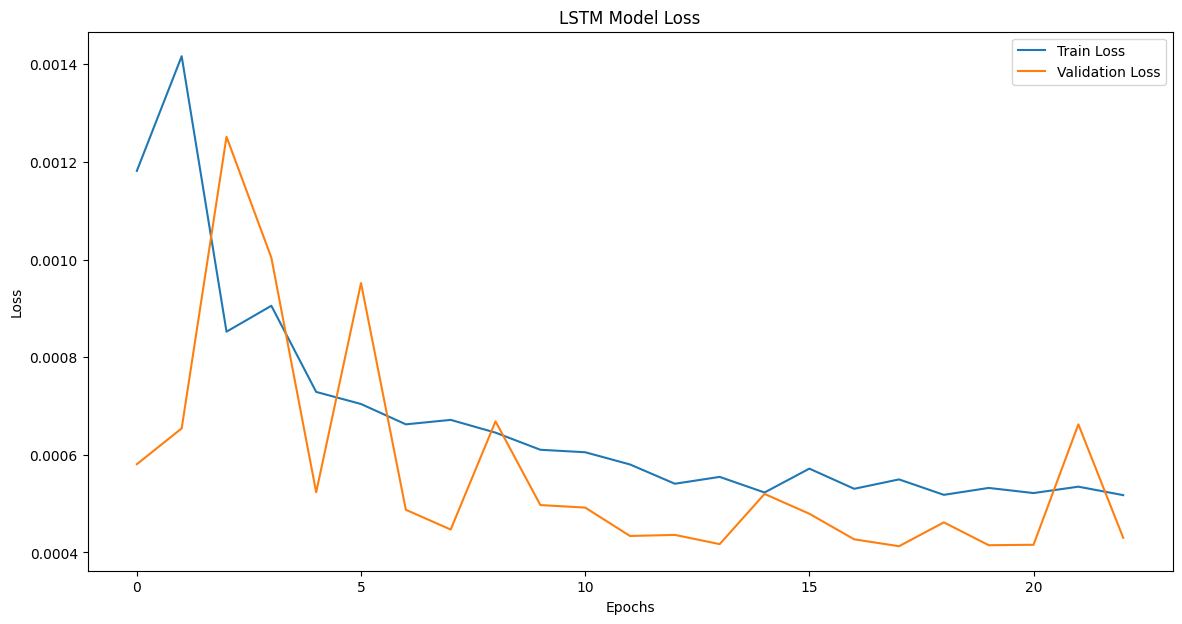

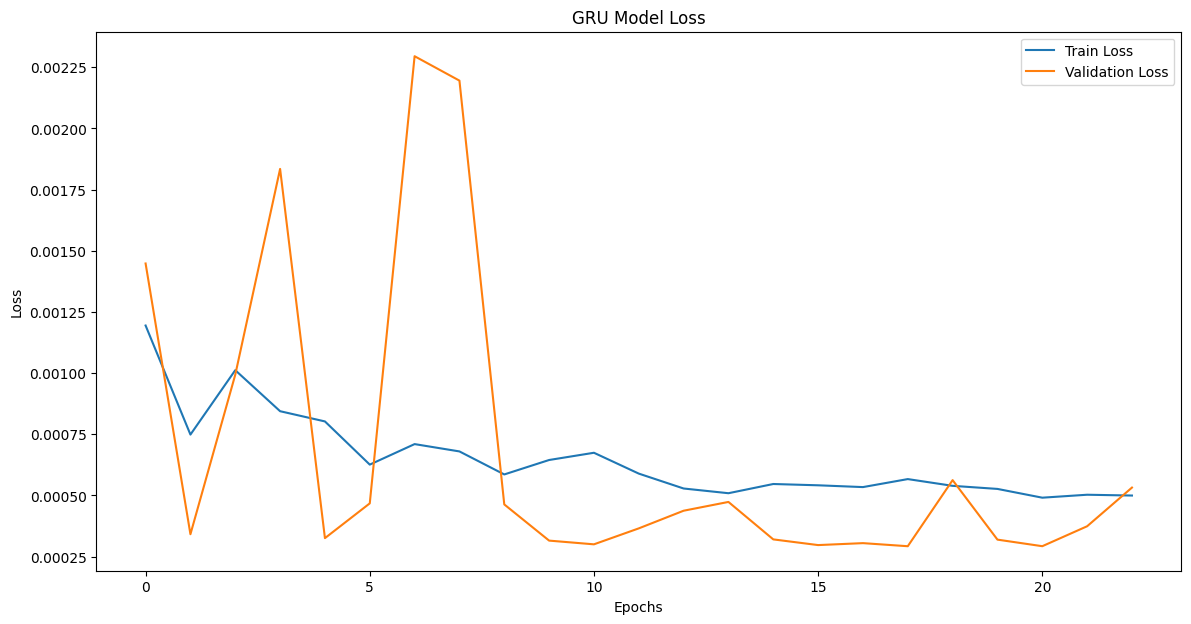

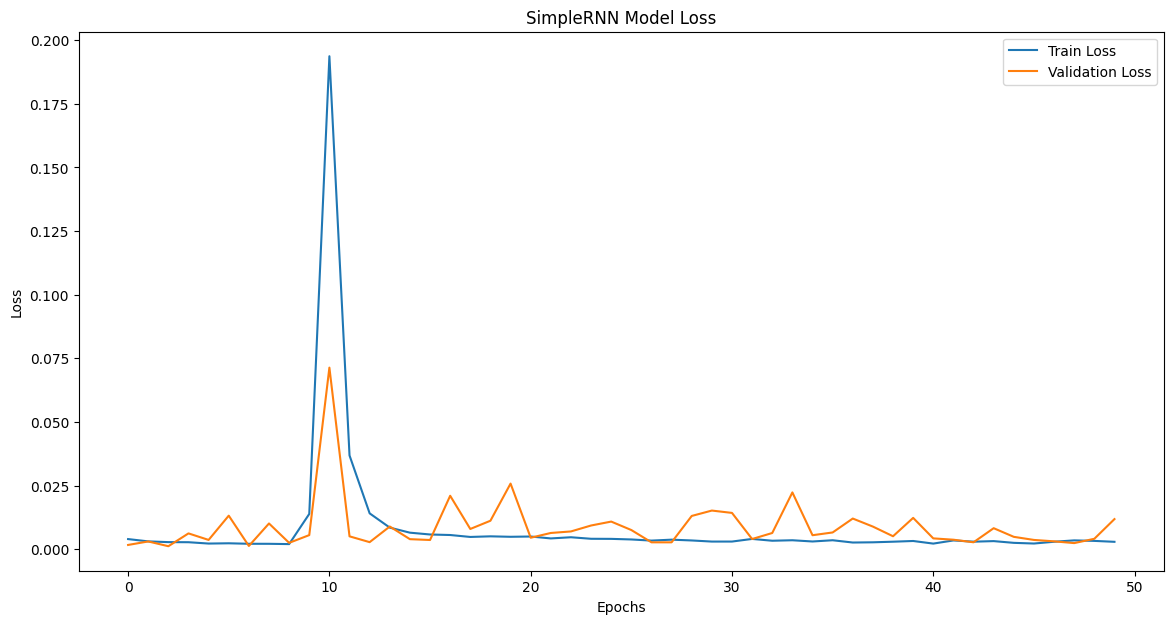

In [ ]:
# Function to plot loss curves
def plot_loss_curves(history, model_name):
    plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

print("Plotting loss curves...")
# Plot loss curves for all models
plot_loss_curves(history_lstm, 'LSTM')
plot_loss_curves(history_gru, 'GRU')
plot_loss_curves(history_rnn, 'SimpleRNN')


Plotting Predictions vs. Actual Values

Plotting predictions vs actual values...


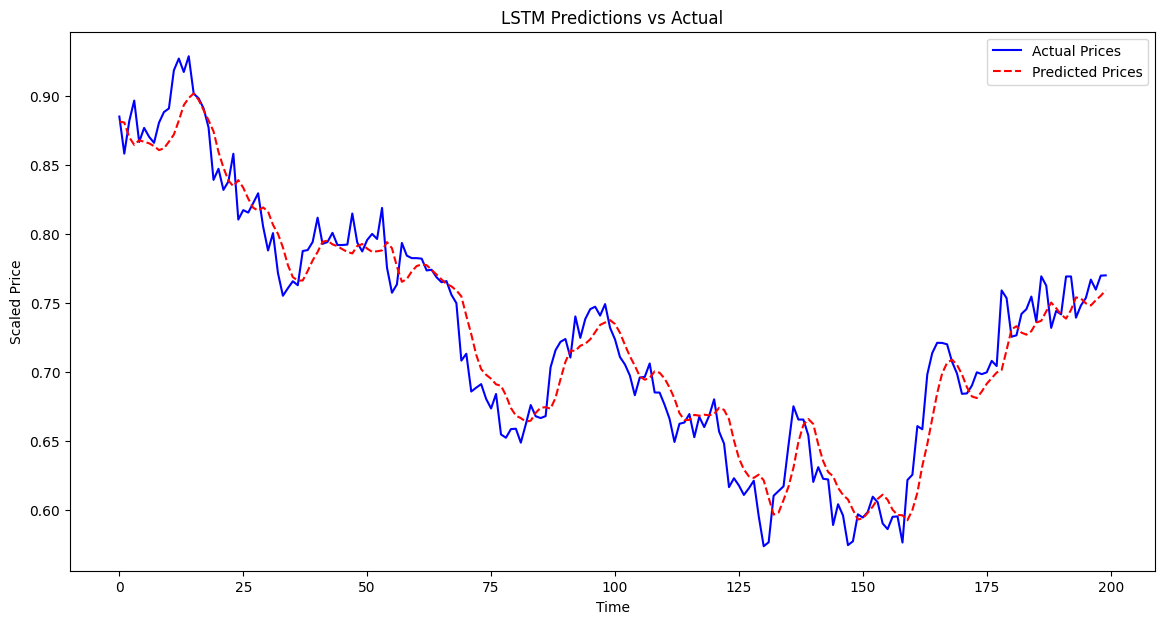

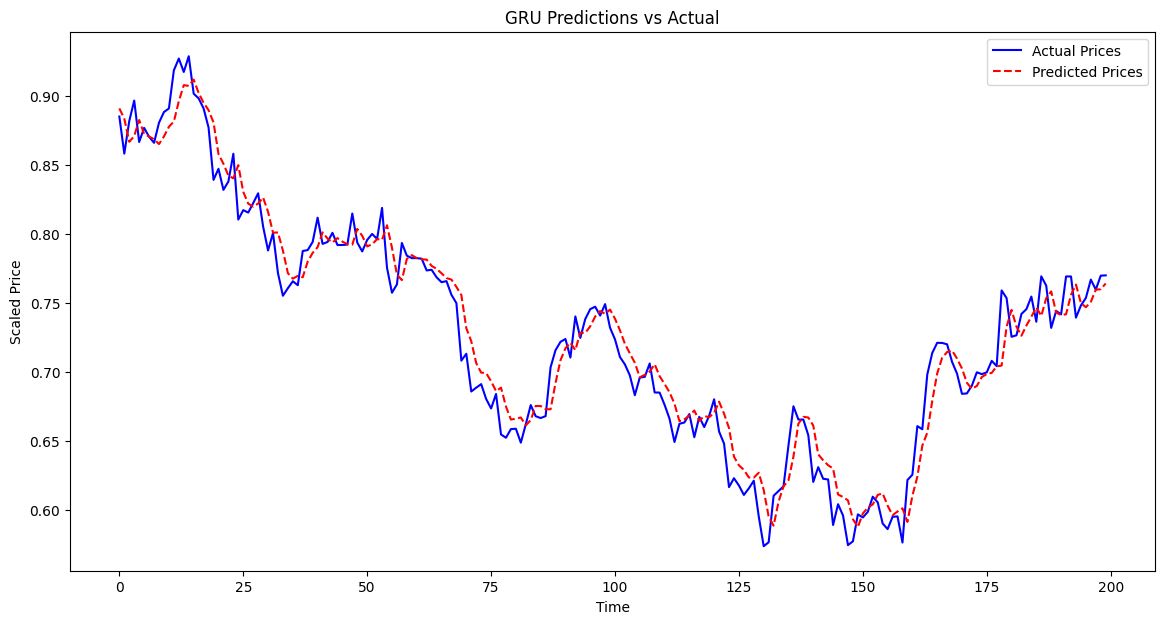

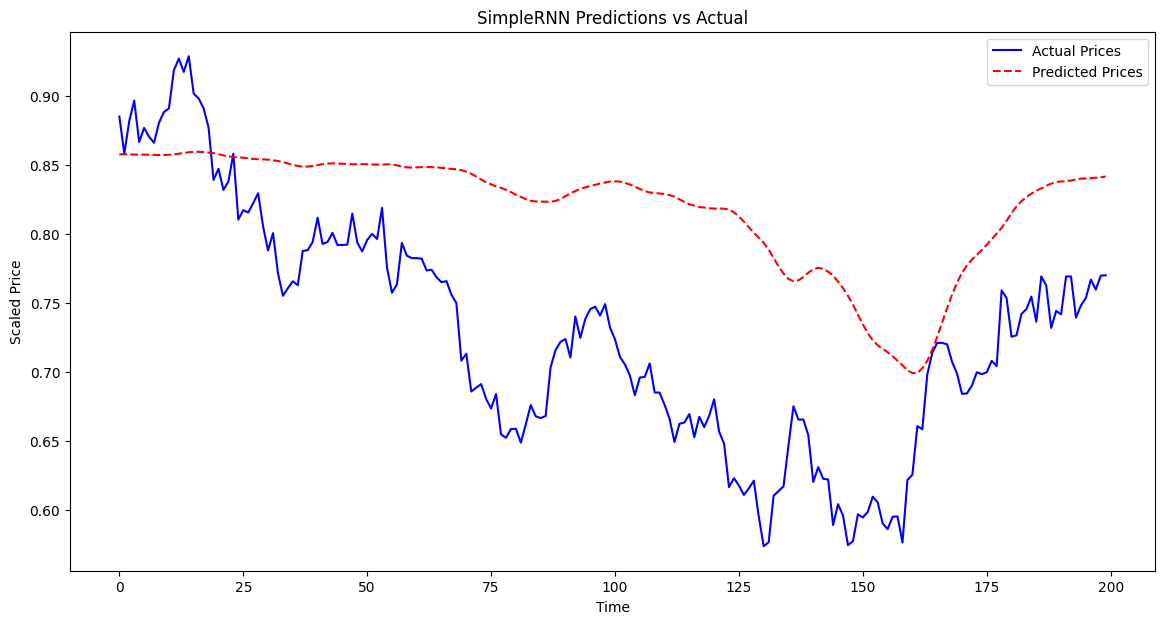

In [ ]:
# Function to plot predictions vs actual values
def plot_predictions(y_test, y_pred, title):
    plt.figure(figsize=(14, 7))
    plt.plot(y_test, color='blue', label='Actual Prices')
    plt.plot(y_pred, color='red', linestyle='--', label='Predicted Prices')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Scaled Price')
    plt.legend()
    plt.show()

print("Plotting predictions vs actual values...")
# Plot predictions for LSTM model
plot_predictions(y_test, y_pred_lstm, 'LSTM Predictions vs Actual')

# Plot predictions for GRU model
plot_predictions(y_test, y_pred_gru, 'GRU Predictions vs Actual')

# Plot predictions for SimpleRNN model
plot_predictions(y_test, y_pred_rnn, 'SimpleRNN Predictions vs Actual')


Summarize Results   
Summarize and compare the performance metrics of the three models.

In [ ]:
# Create a summary of results
results_summary = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'SimpleRNN'],
    'Test Loss': [lstm_result, gru_result, rnn_result],
    'Test MAPE': [lstm_mape, gru_mape, rnn_mape],
    'Test RMSE': [lstm_rmse, gru_rmse, rnn_rmse],
    'Test Accuracy': [lstm_accuracy, gru_accuracy, rnn_accuracy],
    'Training Time (seconds)': [lstm_training_time, gru_training_time, rnn_training_time]
})

print("Summary of results:")
print(results_summary)


Summary of results:
       Model  Test Loss  Test MAPE  Test RMSE  Test Accuracy  \
0       LSTM   0.000419   0.022586   0.020466       0.977414   
1        GRU   0.000325   0.019674   0.018014       0.980326   
2  SimpleRNN   0.012260   0.143128   0.110724       0.856872   

   Training Time (seconds)  
0               564.064487  
1               416.483834  
2               232.467629  
